# Analytic Comparison
This notebook is a test to ensure the results from the numerical DLS model converge to the analytical results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Run the Numerical DLS and compare to analytical


Solving...0.00...7.52...15.05...Complete in 0.9 seconds
Solving...0.00...7.52...15.05...Complete in 1.5 seconds
Solving...0.00...7.52...15.05...Complete in 4.0 seconds
Solving...0.00...7.52...15.05...Complete in 1.5 seconds


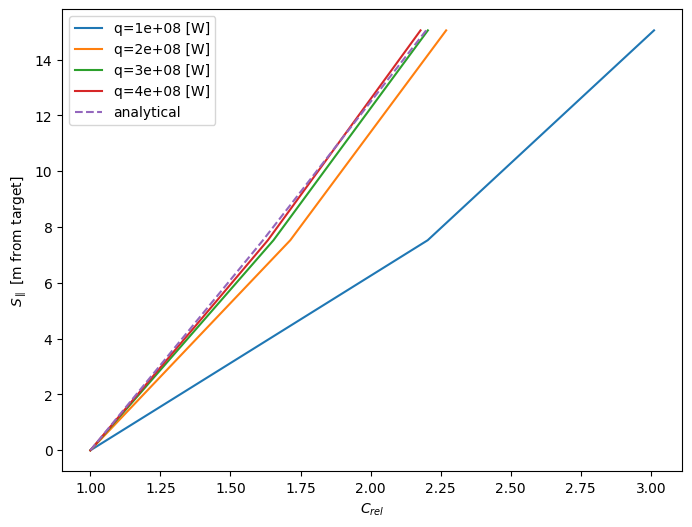

In [2]:
from fusiondls import MagneticGeometry, SimulationInputs, run_dls
from fusiondls.Analytic_DLS import CfInt

profile = MagneticGeometry.from_pickle("eqb_store_lores.pkl", "V10", "ou")

# Solve at these paallel positions
SparRange = np.linspace(0, profile.S[profile.Xpoint - 1], 3)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

endresults = []

for heat_flux in np.linspace(1e8, 4e8, 4):
    settings = SimulationInputs(
        SparRange=SparRange,
        gamma_sheath=7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        Tt=1,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        qpllu0=heat_flux,  # heat flux density at the x point
        nu=1e20,  # Upstream density (if constant)
        nu0=1e20,  # Upstream density (if constant)
        cz0=0.02,  # Impurity fraction (if constant)
        cooling_curve="N",  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        control_variable="density",
        Ttol=1e-3,
        front_sheath=True,
    )
    results = run_dls(settings, profile)
    ax.plot(results.cvar_norm, results["Splot"], label=f"q={heat_flux:g} [W]")
    endresults.append(results.cvar_norm[-1])


resultsAnalytical = [
    CfInt(profile.S, profile.Btot, profile.Sx, np.max(profile.S), sh=s, kappa1=2500)
    for s in SparRange
]

ax.plot(
    resultsAnalytical / resultsAnalytical[0],
    SparRange,
    label="analytical",
    linestyle="--",
)
ax.set_xlabel(r"$C_{rel}$")
ax.set_ylabel(r"$S_{\parallel}$ [m from target]")

ax.legend()
plt.show()

# Results

The percentage error for the detachment window ($C_{rel}$ at the end of the scan) for these results should converge.

In [3]:
# Expect the following results from the analytical model
np.testing.assert_allclose(
    resultsAnalytical[-1] / resultsAnalytical[0], 2.198303859484034, rtol=1e-10
)

# Convergence should occur within 1% of the analytical result
percentage_error = (
    100 * (endresults - resultsAnalytical[-1] / resultsAnalytical[0]) / endresults
)
print(f"{percentage_error=}")
np.testing.assert_allclose(
    percentage_error, [27.00214464, 3.14241826, 0.27699067, -0.92292186]
)

percentage_error=array([27.00214464,  3.14241826,  0.27699067, -0.92292186])
